# Residual Networks

> During training, we might observe the gradients for the shallow layers decrease to zero very rapidly as training proceeds. Residual network helps resolve the issue of the decrease in the speed of learning for the shallow layers in the neural network, while training. Moreover, ResNet blocks with the shortcut also make it very easy for a particular block to learn an identity function. 

In [1]:
# import packages
import os
import tensorflow as tf
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator


%matplotlib inline 

![Identity Block](NB-images\idblock3_kiank.png)
**Fig 1: Identity Block.** Shows the main path and the shortcut connection

In [2]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    
    """
    Identity block of the Residual Network - where the input activation (a[l]) has the same
    dimension as the output activation (a[l+2]).
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer())(X)
    
    # To speed up training
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis and training is true to train the weights
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer())(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer())(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    # Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

![Convolutional Block](NB-images\convblock_kiank.png)
**Fig 2: Convolutional Block**

In [3]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block. It is used when the input and output dimensions don't
    match up.
    
    It resizes the input X to a different dimension, so that the dimensions match up in the
    final addition needed to add the shortcut value back to the main path.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path 
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer())(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer())(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer())(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    # Shortcut path 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

![ResNet-50](NB-images\resnet_kiank.png)
**Fig 3: ResNet-50 model**

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):

    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Input tensor
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(filters = 64, kernel_size=(7,7), strides=(2, 2), kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    
    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL 
    X = AveragePooling2D((2, 2))(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform())(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes= 6)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
_______________________________________________________________________________________

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Prepare the data
**Dataset:** the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [7]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples = 1080
Number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [8]:
history = model.fit(X_train, Y_train, epochs = 18, batch_size = 32);

Epoch 1/18
34/34 [==============================] - 5s 148ms/step - loss: 1.7726 - accuracy: 0.4630
Epoch 2/18
34/34 [==============================] - 4s 106ms/step - loss: 0.6946 - accuracy: 0.7676
Epoch 3/18
34/34 [==============================] - 4s 106ms/step - loss: 0.4456 - accuracy: 0.8417
Epoch 4/18
34/34 [==============================] - 4s 106ms/step - loss: 0.4588 - accuracy: 0.8657
Epoch 5/18
34/34 [==============================] - 4s 107ms/step - loss: 0.3841 - accuracy: 0.8861
Epoch 6/18
34/34 [==============================] - 4s 105ms/step - loss: 0.1395 - accuracy: 0.9435
Epoch 7/18
34/34 [==============================] - 4s 104ms/step - loss: 0.0763 - accuracy: 0.97130s - loss: 0.0763 - accuracy: 0.97
Epoch 8/18
34/34 [==============================] - 4s 105ms/step - loss: 0.1276 - accuracy: 0.9565
Epoch 9/18
34/34 [==============================] - 4s 105ms/step - loss: 0.2705 - accuracy: 0.9222
Epoch 10/18
34/34 [==============================] - 4s 105ms/step

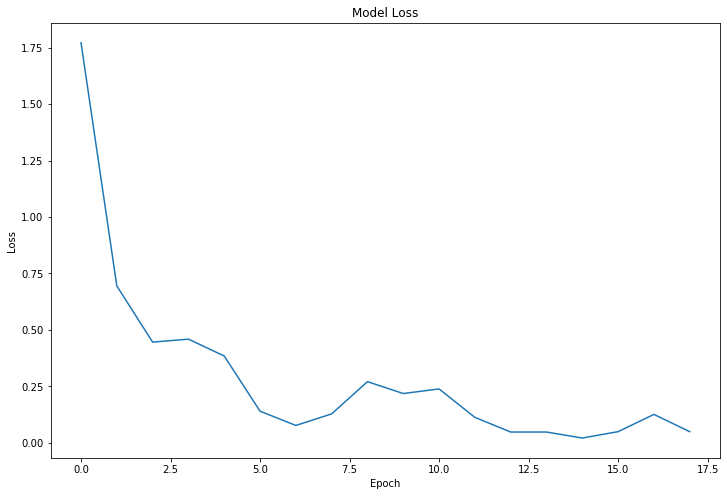

In [9]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc['loss']
df_loss.rename('train', inplace=True)

df_acc = df_loss_acc['accuracy']
df_acc.rename('train', inplace=True)

df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss');

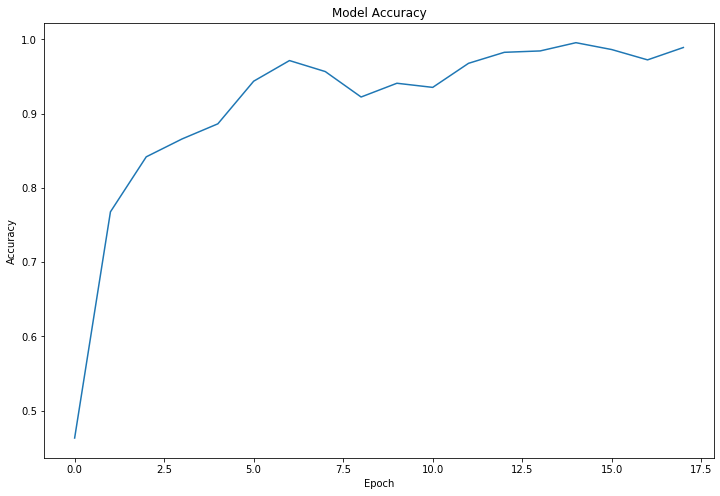

In [10]:
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy');

In [11]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 0s 24ms/step - loss: 0.2711 - accuracy: 0.9417
Loss = 0.271067351102829
Test Accuracy = 0.9416666626930237


## Test your own image

In [12]:
dir_path = ""
img_filename = "hand-digit-3.JPG"

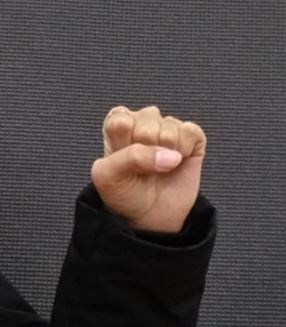

In [13]:
# Display the image
Image(dir_path + img_filename)

In [14]:
def test_image(dir_path, image_filename):
    
    # Prepare our input image for the model
    img = image.load_img(dir_path + image_filename, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.
    print(f"Image shape after transformations: {x.shape}\n")
    prediction = model.predict(x)
    
    # Confidence scores
    print("Confidence Scores: ")

    for i in range(prediction.shape[1]):
        print(f"Class {i} =", float(prediction[:,i]))

    print(f"\nClass Number with highest probability score: {np.argmax(prediction)}")
    
    return prediction

In [15]:
# Make predictions
prediction = test_image(dir_path, img_filename)

Image shape after transformations: (1, 64, 64, 3)

Confidence Scores: 
Class 0 = 0.9694945812225342
Class 1 = 0.0034024864435195923
Class 2 = 0.008305735886096954
Class 3 = 0.003947461489588022
Class 4 = 0.012707065790891647
Class 5 = 0.0021426964085549116

Class Number with highest probability score: 0


In [16]:
# Save model
model.save("model_resnet50.h5")